In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline


# Load data
df = pd.read_excel("../data/raw/Data1.xlsx")
df.head()

,Düse,MFI,Trial ID,Rohstoff,conveyor belt speed [m/min],throughput [kg/h],melt temperature die tip,process air volume [m³/h],process air temperature [°C],secondary air temperature [°C],...,AC2 throughput (%),AC3 resin (X = Kein Additive verwendet),AC3 throughput (%),AC4 resin (X = Kein Additive verwendet),AC4 throughput (%),Hydrocharging pump speed,fabric weight (act) [g/m²],thickness [mm],air permeability [l/m²s],"DEHS @15,8 cm/s\nFractional Efficiency 0.3µm"
0,2.0,1550,23.03.0034,1,24.902344,24.59016,250.95,1070,262.395,19.95,...,0.0,X,0.0,X,0,60.0,16.014167,0.182,1032.833333,82.20325
1,2.0,1550,23.03.0035,1,37.536621,24.59016,248.85,1070,262.395,18.90,...,0.0,X,0.0,X,0,60.0,10.926667,0.177,1380.000000,62.641285
2,2.0,1550,23.03.0036,1,37.487793,24.59016,247.80,849,262.395,19.95,...,0.0,X,0.0,X,0,60.0,10.683333,0.189,1718.750000,60.858468
3,2.0,1550,23.03.0037,1,25.000000,24.59016,246.75,837,262.185,18.90,...,0.0,X,0.0,X,0,60.0,15.900833,0.226,1147.500000,77.665585
4,2.0,1550,23.03.0038,1,25.109863,24.59016,247.80,1069,262.605,18.90,...,0.0,X,0.0,X,0,60.0,16.193333,0.203,772.875000,11.767833


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 26 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Düse                                         117 non-null    float64
 1   MFI                                          119 non-null    int64  
 2   Trial ID                                     119 non-null    object 
 3   Rohstoff                                     119 non-null    int64  
 4   conveyor belt speed [m/min]                  119 non-null    float64
 5   throughput [kg/h]                            119 non-null    float64
 6   melt temperature die tip                     119 non-null    float64
 7   process air volume [m³/h]                    119 non-null    int64  
 8   process air temperature [°C]                 119 non-null    float64
 9   secondary air temperature [°C]               119 non-null    floa

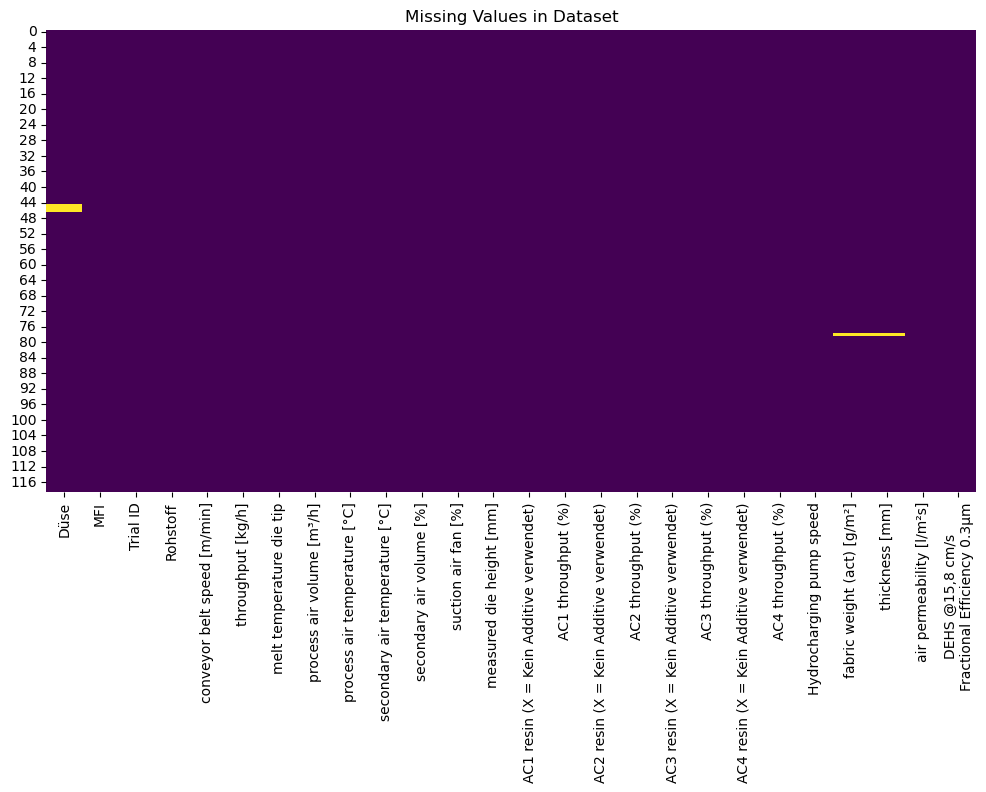

In [2]:
# Basic info
print("Data Info:")
df.info()

# Missing value heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Dataset")
plt.show()

In [4]:
# Drop Trial ID and columns with <90% data
df_clean = df.drop(columns=['Trial ID'], errors='ignore')
threshold_col = 0.9 * len(df_clean)
df_clean = df_clean.dropna(thresh=threshold_col, axis=1)

# Drop rows with >90% missing
threshold_row = 0.1 * df_clean.shape[1]
df_clean = df_clean.dropna(thresh=threshold_row, axis=0)
df_clean.reset_index(drop=True, inplace=True)

#replace all values '-' with np.nan
df_clean.replace('-', np.nan, inplace=True)

C:\Users\araychaudhury\AppData\Local\Temp\ipykernel_30360\1111502667.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean.replace('-', np.nan, inplace=True)


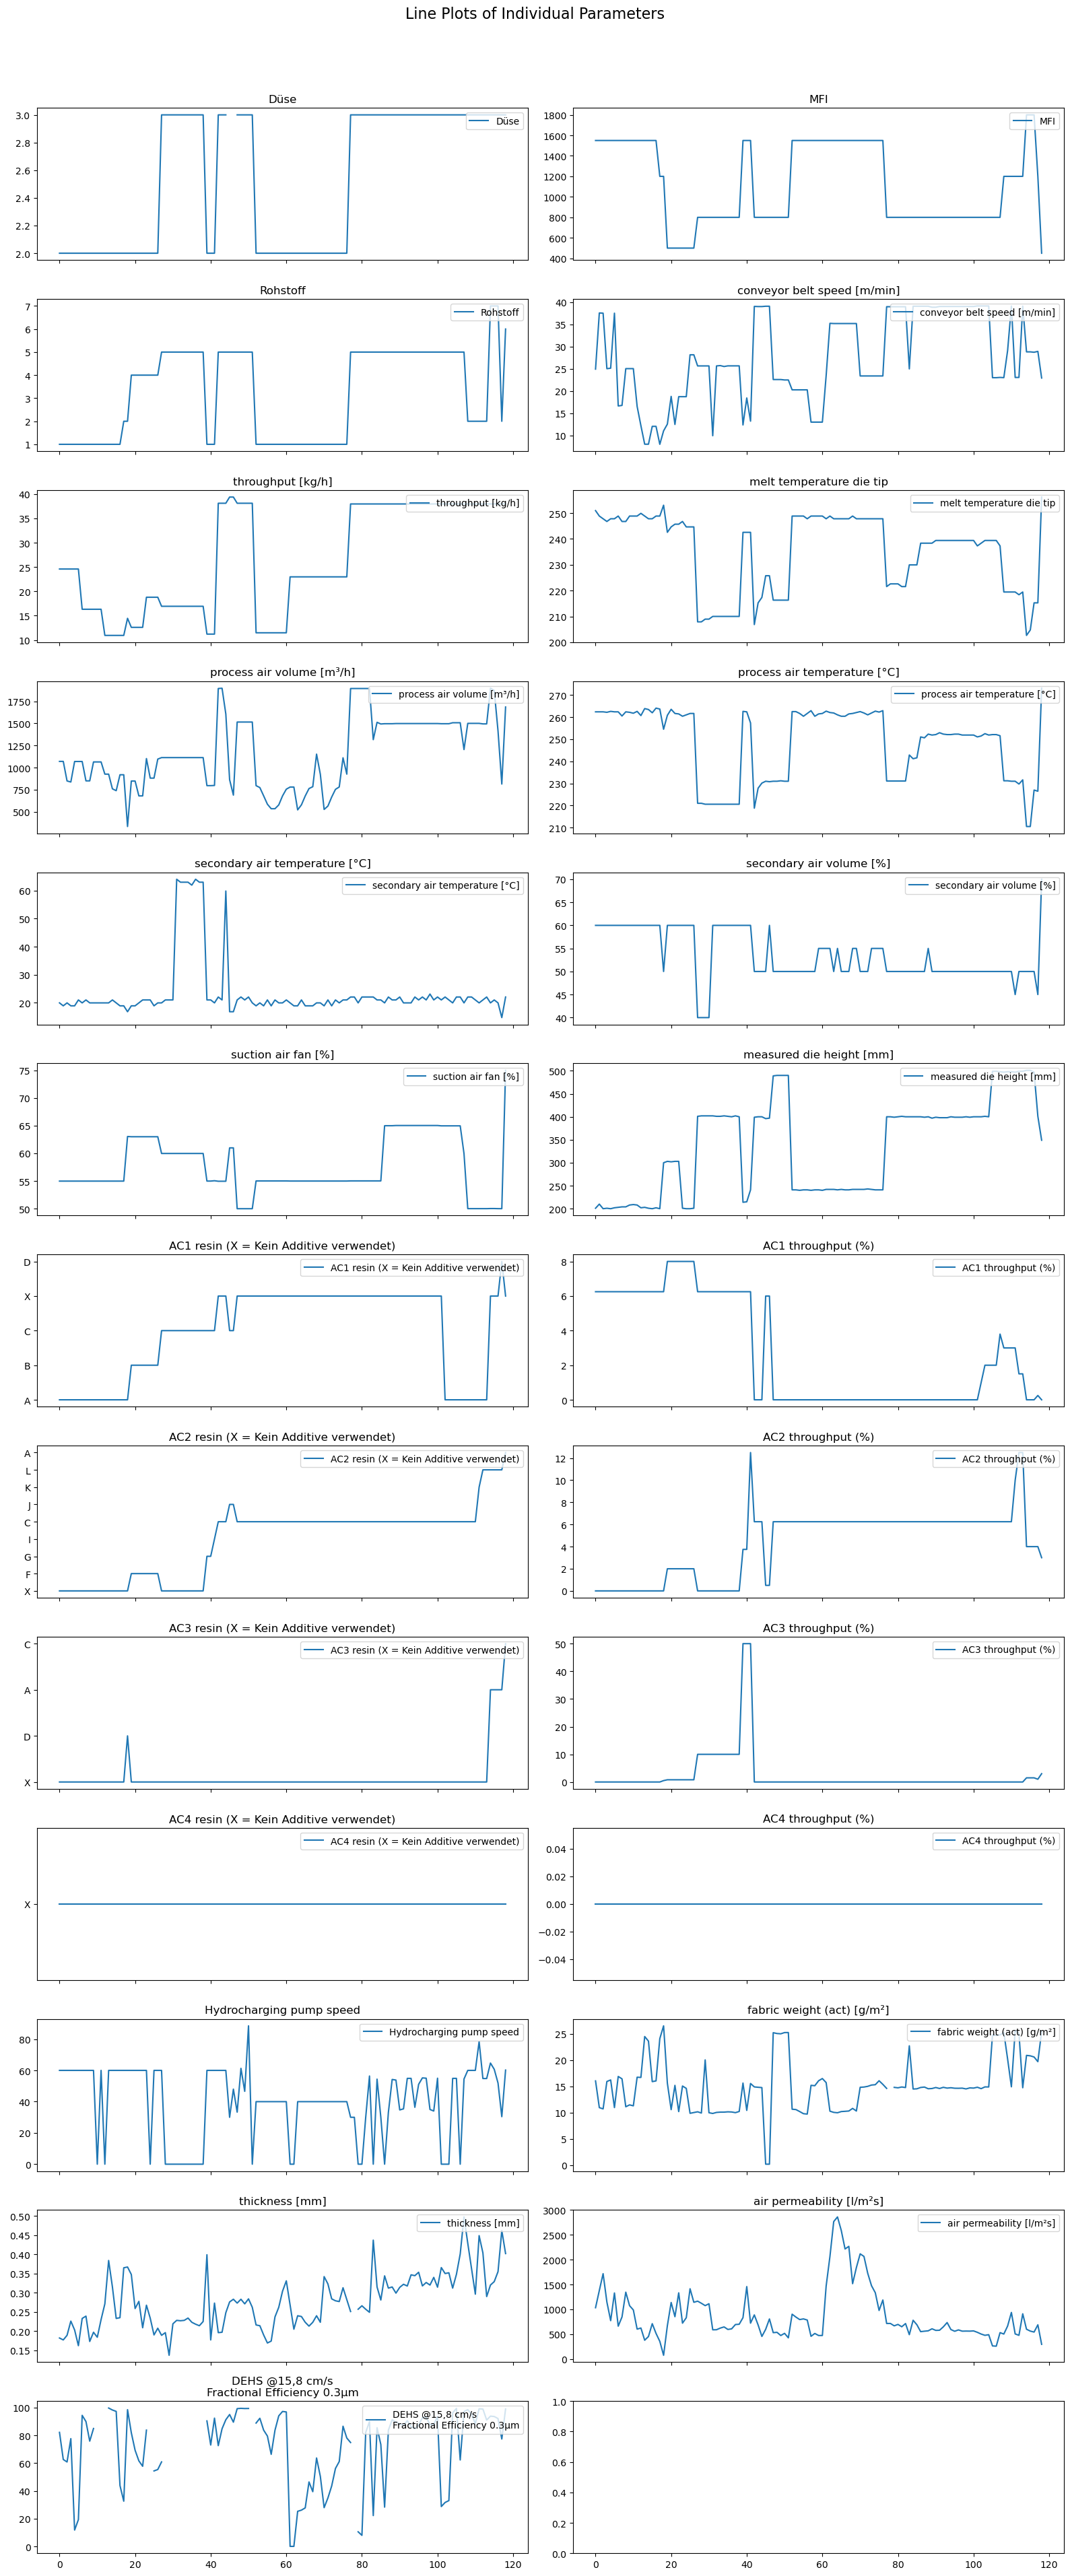

In [5]:
n_cols = 2  # number of columns for subplots
n_rows = int(np.ceil(len(df_clean.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3), sharex=True)

axes = axes.flatten()  # flatten in case it's 2D

for i, col in enumerate(df_clean.columns):
    axes[i].plot(df_clean[col], label=col, color='tab:blue')
    axes[i].set_title(col)
    axes[i].legend(loc='upper right')

plt.suptitle("Line Plots of Individual Parameters", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [6]:
#Replace DEHS @15,8 cm/s\nFractional Efficiency 0.3µm with Fractional Efficiency
df_clean.rename(columns={'DEHS @15,8 cm/s\nFractional Efficiency 0.3µm': 'Fractional Efficiency'}, inplace=True)

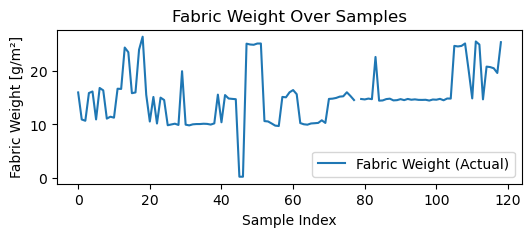

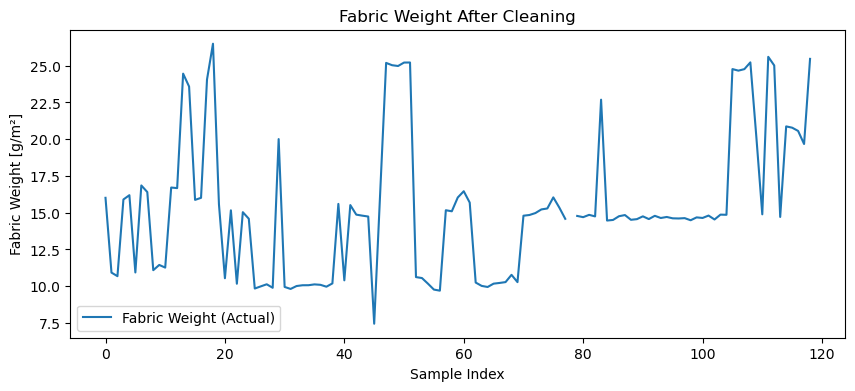

In [9]:
# plot fabric weight  
plt.figure(figsize=(6, 2))
plt.plot(df_clean['fabric weight (act) [g/m²]'], label='Fabric Weight (Actual)', color='tab:blue')
plt.title('Fabric Weight Over Samples')
plt.xlabel('Sample Index')
plt.ylabel('Fabric Weight [g/m²]')
plt.legend()
plt.show()

# Replace fabric weight values below 5g/m² with avg of neighbors
fw_col = 'fabric weight (act) [g/m²]'
for i in range(1, len(df_clean) - 1):
    if df_clean.loc[i, fw_col] < 5:
        df_clean.loc[i, fw_col] = (df_clean.loc[i - 1, fw_col] + df_clean.loc[i + 1, fw_col]) / 2
# Plot fabric weight 
plt.figure(figsize=(10, 4))
plt.plot(df_clean['fabric weight (act) [g/m²]'], label='Fabric Weight (Actual)', color='tab:blue')
plt.title('Fabric Weight After Cleaning')
plt.xlabel('Sample Index')
plt.ylabel('Fabric Weight [g/m²]')
plt.legend()
plt.show()

In [10]:
#remove all rows with fractional efficiency 0
df_clean = df_clean[df_clean['Fractional Efficiency'] > 0]

In [11]:
df_clean

,Düse,MFI,Rohstoff,conveyor belt speed [m/min],throughput [kg/h],melt temperature die tip,process air volume [m³/h],process air temperature [°C],secondary air temperature [°C],secondary air volume [%],...,AC2 throughput (%),AC3 resin (X = Kein Additive verwendet),AC3 throughput (%),AC4 resin (X = Kein Additive verwendet),AC4 throughput (%),Hydrocharging pump speed,fabric weight (act) [g/m²],thickness [mm],air permeability [l/m²s],Fractional Efficiency
0,2.0,1550,1,24.902344,24.590160,250.95,1070,262.395,19.95,60,...,0.0,X,0.0,X,0,60.000000,16.014167,0.182,1032.833333,82.203250
1,2.0,1550,1,37.536621,24.590160,248.85,1070,262.395,18.90,60,...,0.0,X,0.0,X,0,60.000000,10.926667,0.177,1380.000000,62.641285
2,2.0,1550,1,37.487793,24.590160,247.80,849,262.395,19.95,60,...,0.0,X,0.0,X,0,60.000000,10.683333,0.189,1718.750000,60.858468
3,2.0,1550,1,25.000000,24.590160,246.75,837,262.185,18.90,60,...,0.0,X,0.0,X,0,60.000000,15.900833,0.226,1147.500000,77.665585
4,2.0,1550,1,25.109863,24.590160,247.80,1069,262.605,18.90,60,...,0.0,X,0.0,X,0,60.000000,16.193333,0.203,772.875000,11.767833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,3.0,1800,7,28.784180,37.956600,202.65,1898,210.525,19.95,50,...,4.0,A,1.5,X,0,64.697266,20.873125,0.320,599.625000,93.886164
115,3.0,1800,7,28.784180,37.956600,204.75,1871,210.525,21.00,50,...,4.0,A,1.5,X,0,60.699463,20.785625,0.329,562.625000,93.618670
116,3.0,1800,7,28.698730,37.956600,215.25,1414,227.010,19.95,50,...,4.0,A,1.5,X,0,51.898193,20.564375,0.355,542.875000,92.162339
117,3.0,1200,2,28.894043,37.956600,215.25,814,226.485,14.70,45,...,4.0,A,1.0,X,0,30.401611,19.675000,0.462,688.750000,77.415281


In [12]:
# Categorical encoding for Resins
df_clean['AC1 resin (X = Kein Additive verwendet)'] = df_clean['AC1 resin (X = Kein Additive verwendet)'].astype('category').cat.codes
df_clean['AC2 resin (X = Kein Additive verwendet)'] = df_clean['AC2 resin (X = Kein Additive verwendet)'].astype('category').cat.codes
df_clean['AC3 resin (X = Kein Additive verwendet)'] = df_clean['AC3 resin (X = Kein Additive verwendet)'].astype('category').cat.codes
df_clean['AC4 resin (X = Kein Additive verwendet)'] = df_clean['AC4 resin (X = Kein Additive verwendet)'].astype('category').cat.codes

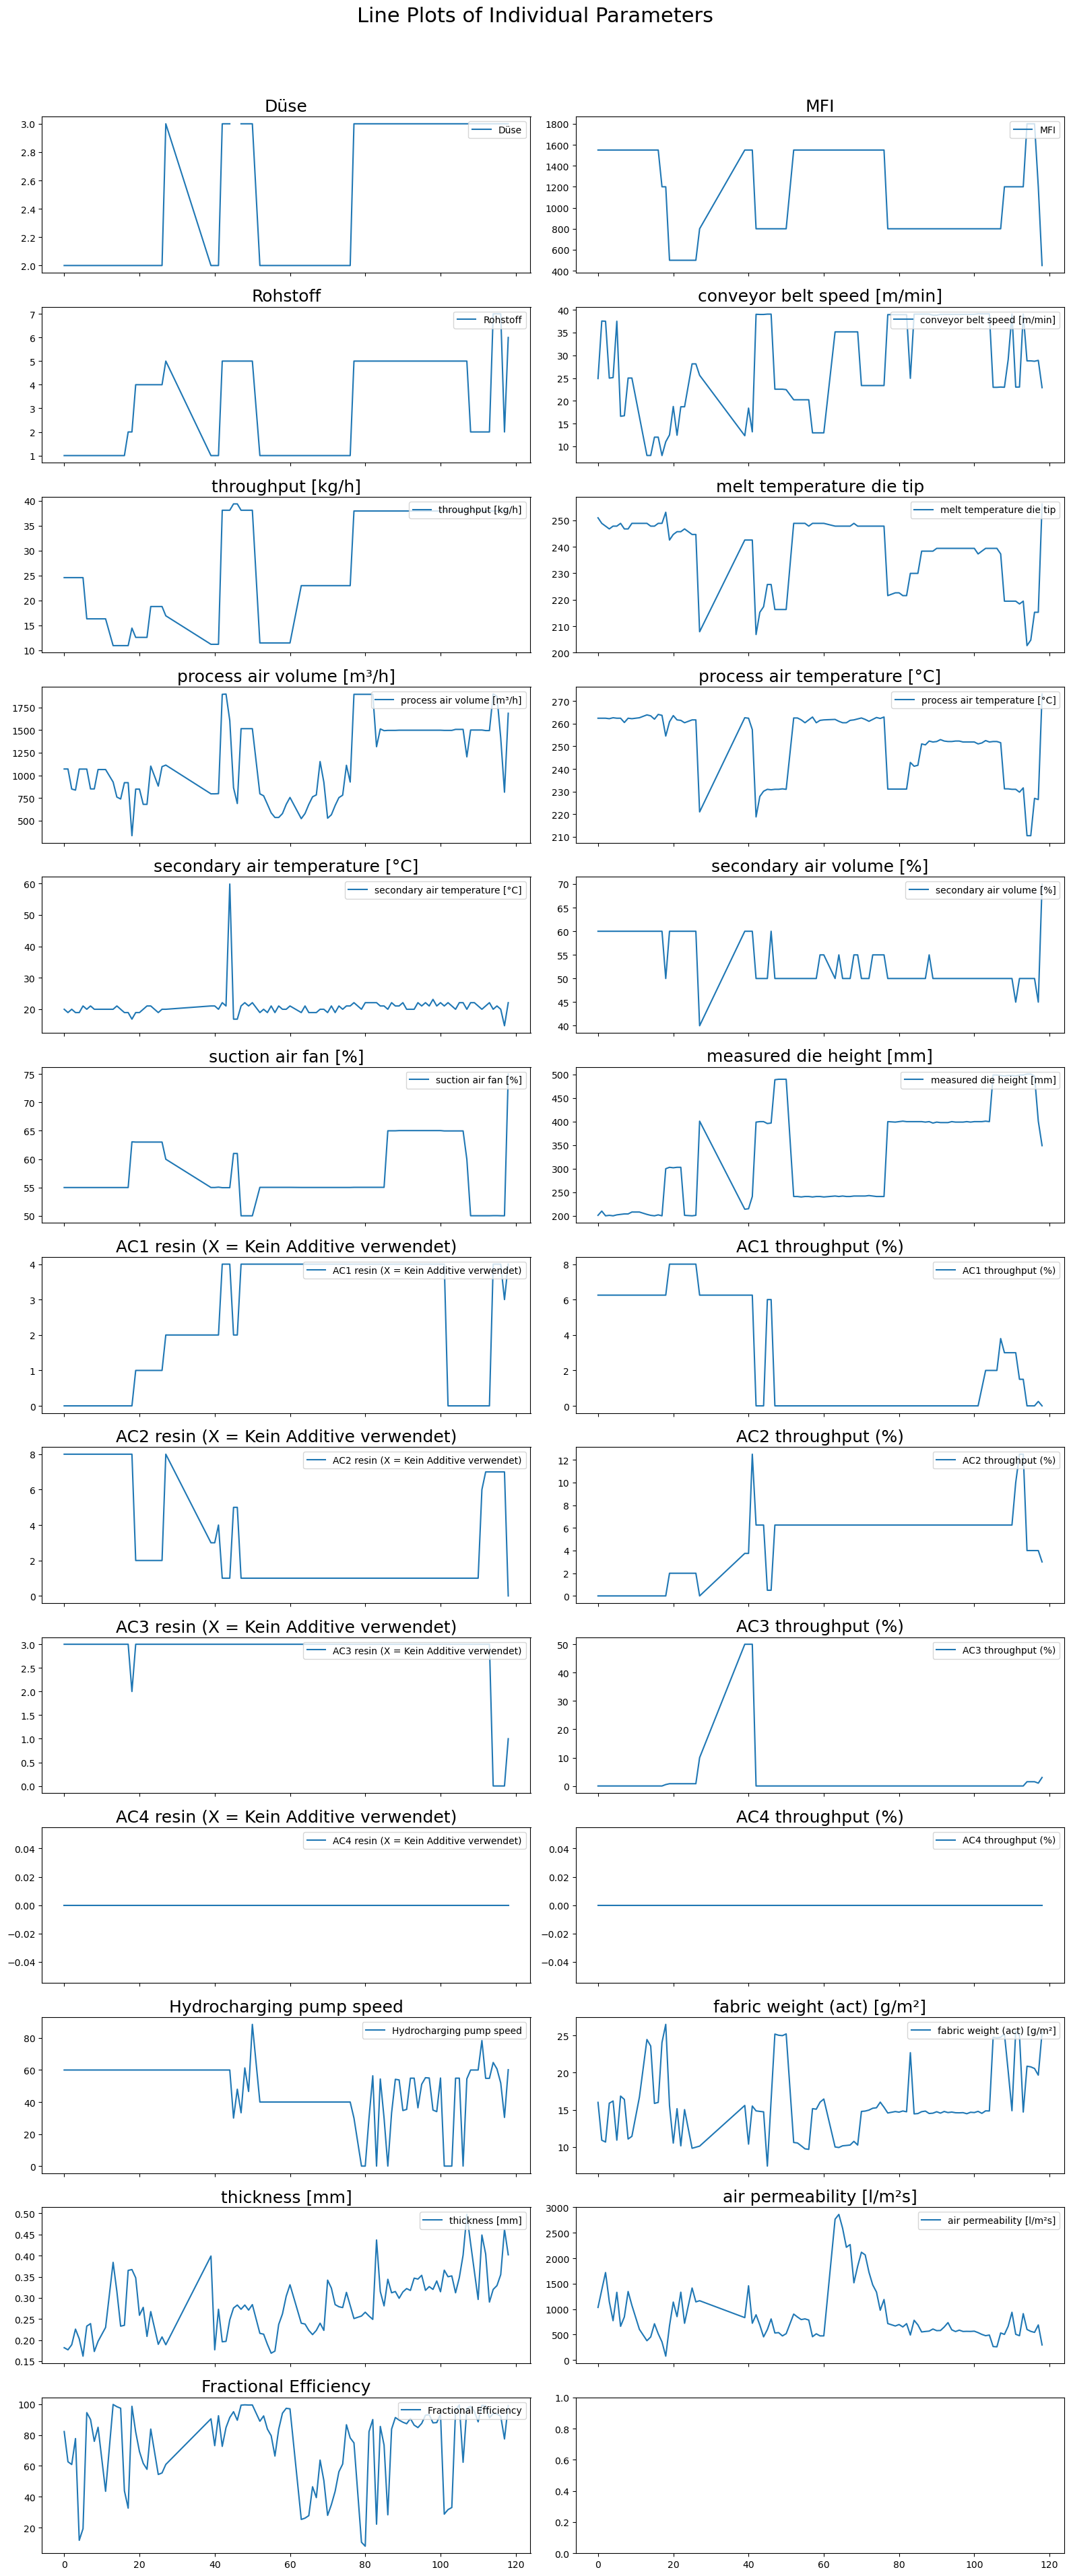

In [13]:
n_cols = 2  # number of columns for subplots
n_rows = int(np.ceil(len(df_clean.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3), sharex=True)

axes = axes.flatten()  # flatten in case it's 2D

for i, col in enumerate(df_clean.columns):
    axes[i].plot(df_clean[col], label=col, color='tab:blue')
    axes[i].set_title(col)
    axes[i].legend(loc='upper right')

plt.suptitle("Line Plots of Individual Parameters", fontsize=22)
#set all fonts to 14
for ax in axes:
    ax.title.set_fontsize(18)
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
#set xlabel font size to 16
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [14]:
# Drop columns where all values are 0
df_clean = df_clean.loc[:, (df_clean != 0).any(axis=0)]

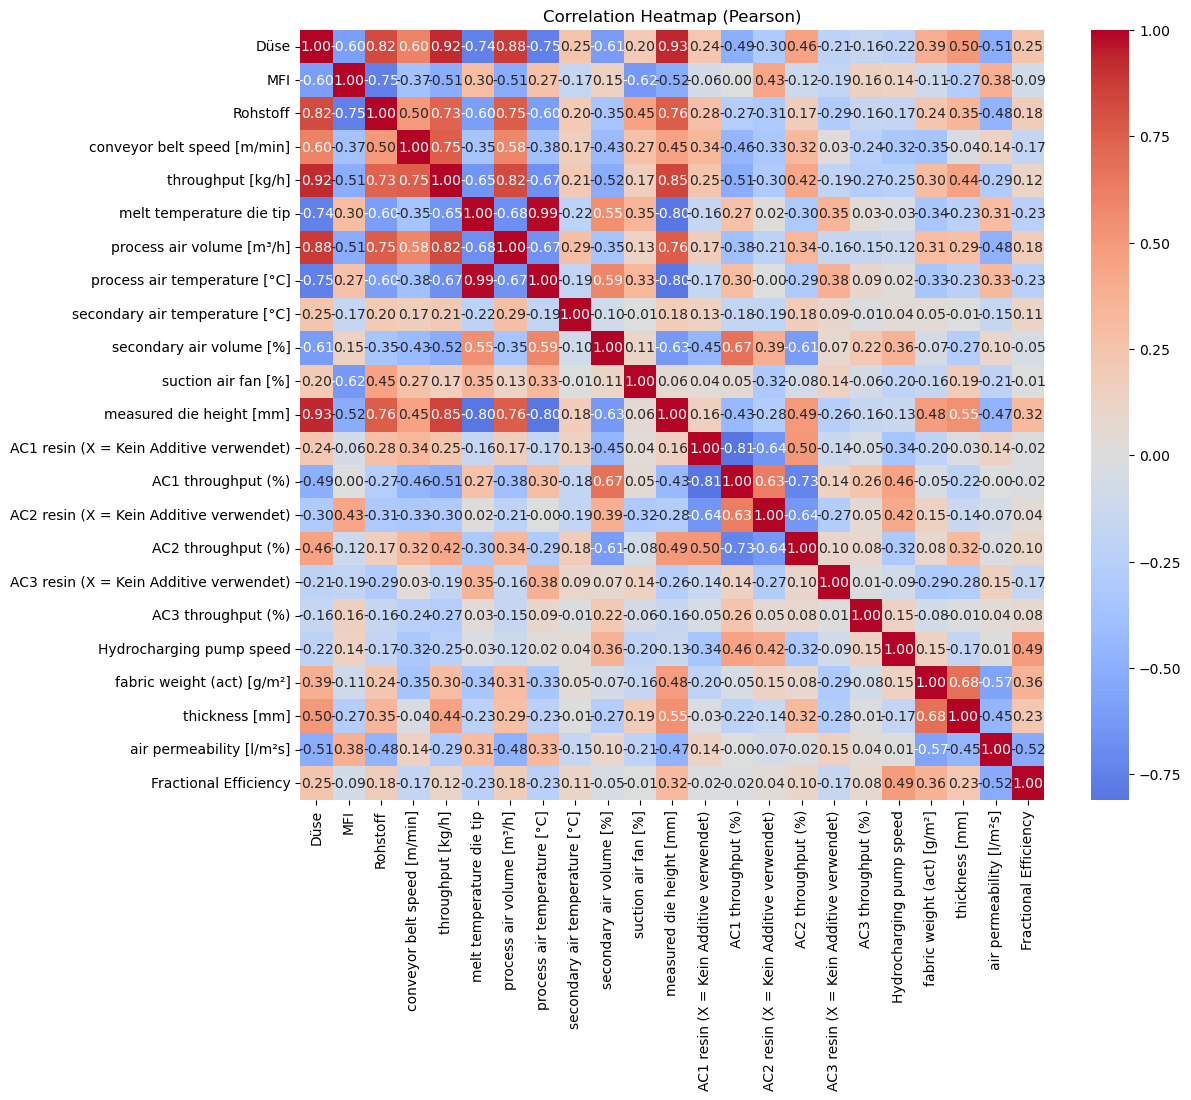

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title("Correlation Heatmap (Pearson)")
plt.show()

In [16]:
outputs = ['fabric weight (act) [g/m²]', 'thickness [mm]', 'air permeability [l/m²s]', 'Fractional Efficiency']

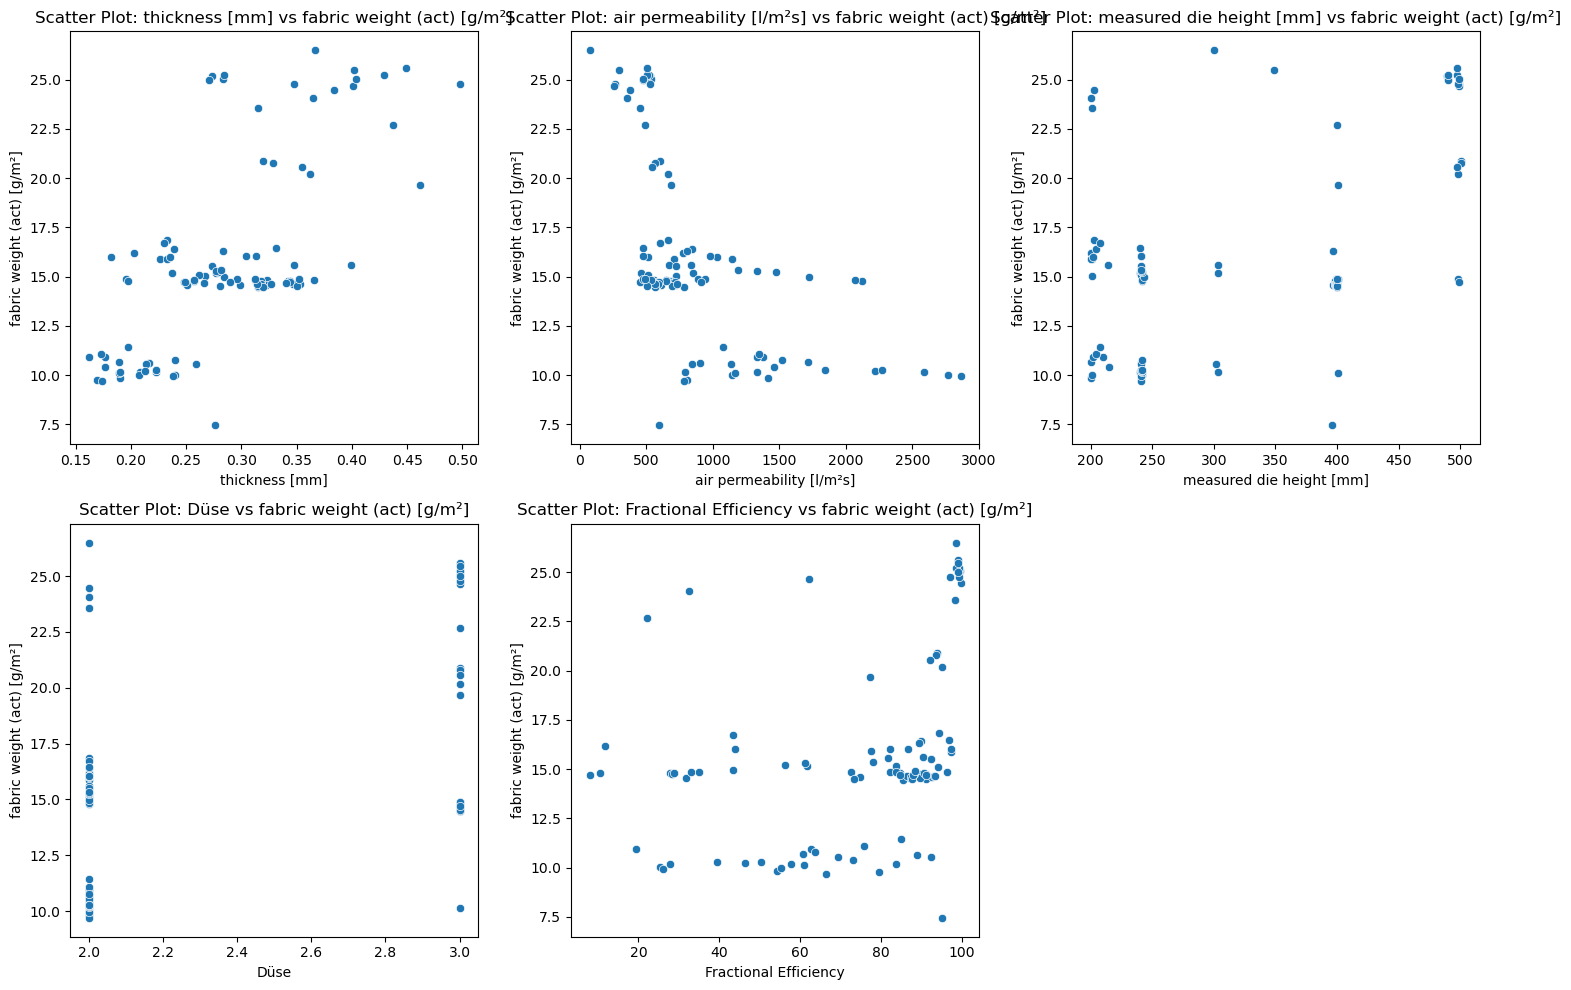

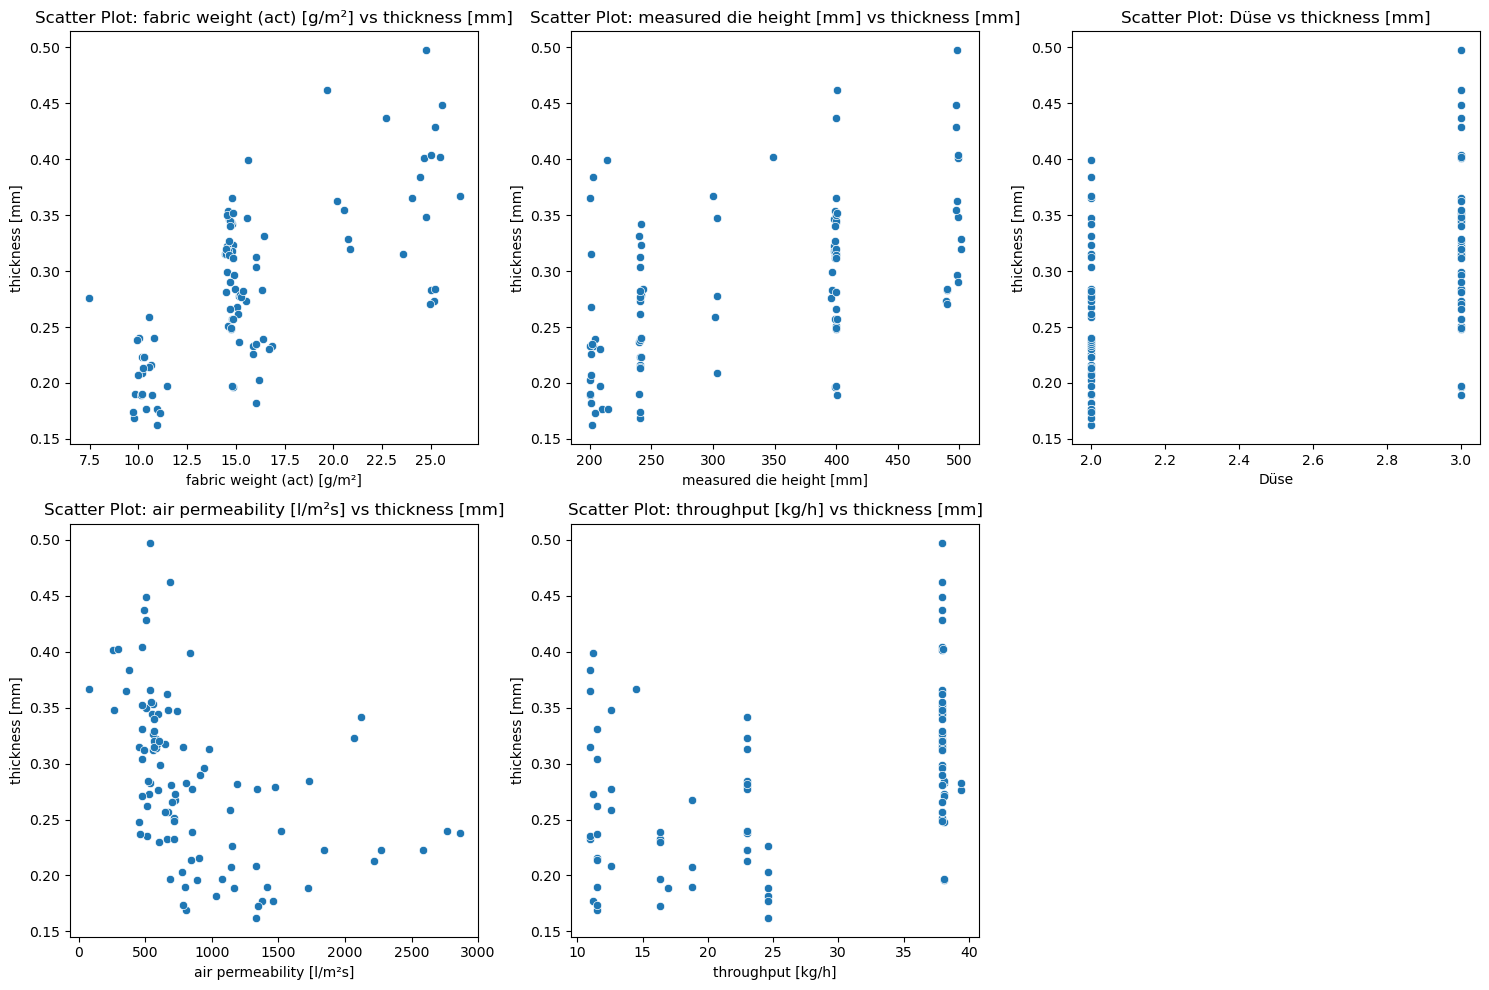

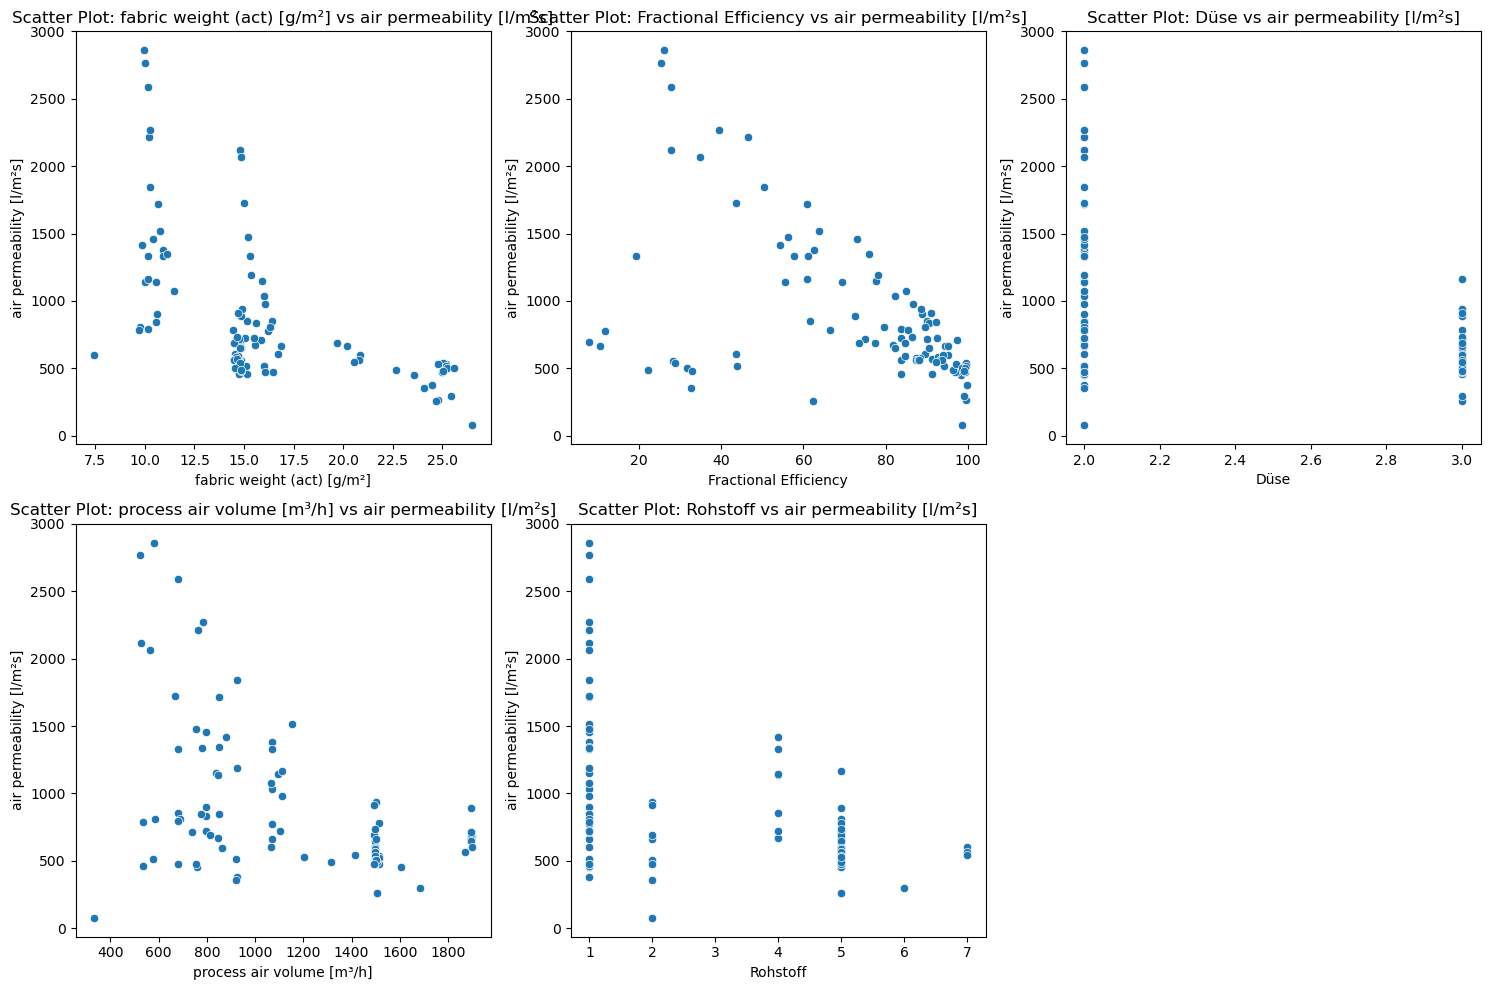

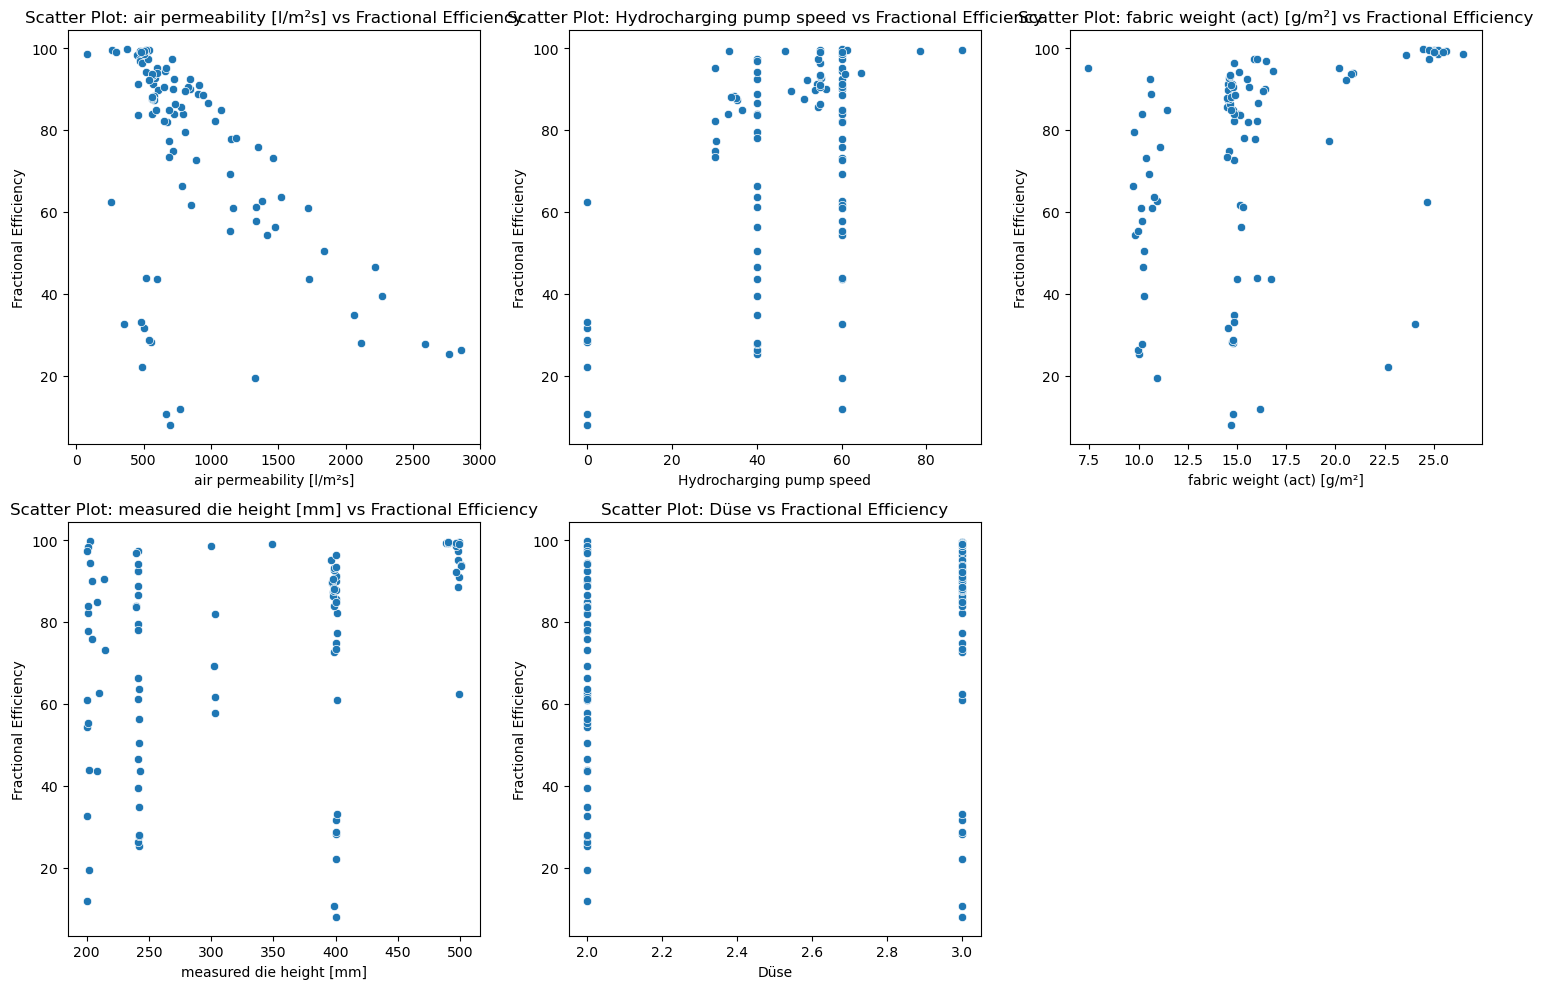

In [17]:
#plot pairwise correlation scatter plots for top 5 correlated features with each output
for output in outputs:
    corr_matrix = df_clean.corr(numeric_only=True)
    top_features = corr_matrix[output].abs().sort_values(ascending=False).head(6).index.tolist()
    top_features.remove(output)

    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(top_features):
        plt.subplot(2, 3, i + 1)
        sns.scatterplot(data=df_clean, x=feature, y=output)
        plt.title(f'Scatter Plot: {feature} vs {output}')
    plt.tight_layout()
    plt.show()

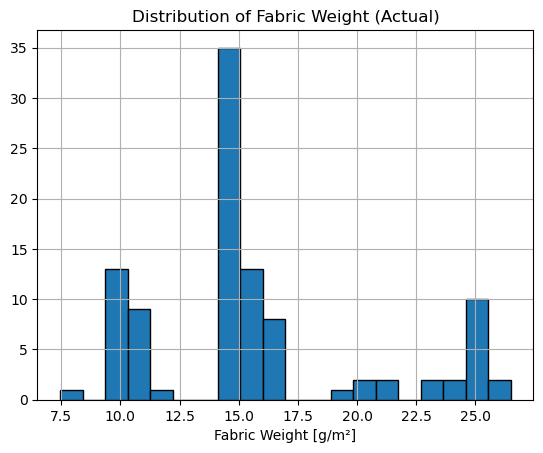

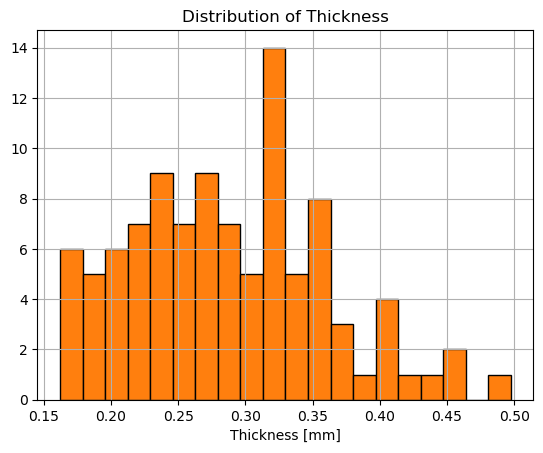

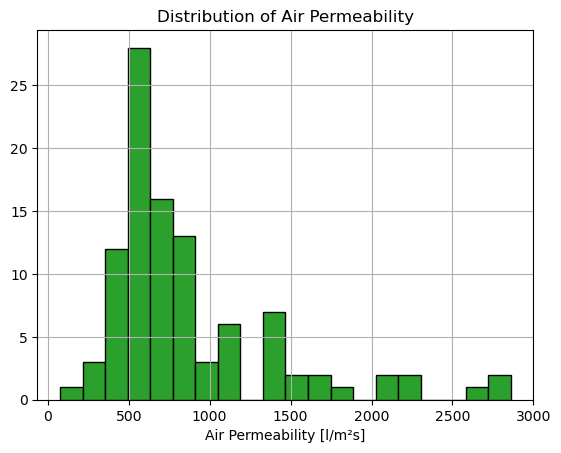

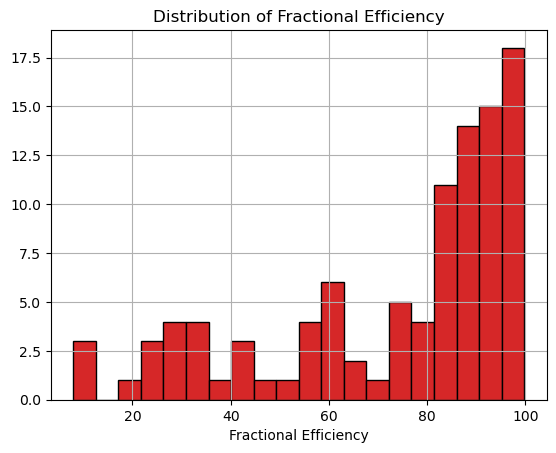

In [18]:
df_clean[outputs[0]].hist(bins=20, color='tab:blue', edgecolor='black')
plt.title('Distribution of Fabric Weight (Actual)')
plt.xlabel('Fabric Weight [g/m²]')
plt.show()
df_clean[outputs[1]].hist(bins=20, color='tab:orange', edgecolor='black')
plt.title('Distribution of Thickness')
plt.xlabel('Thickness [mm]')
plt.show()
df_clean[outputs[2]].hist(bins=20, color='tab:green', edgecolor='black')
plt.title('Distribution of Air Permeability')
plt.xlabel('Air Permeability [l/m²s]')
plt.show()
df_clean[outputs[3]].hist(bins=20, color='tab:red', edgecolor='black')
plt.title('Distribution of Fractional Efficiency')
plt.xlabel('Fractional Efficiency')
plt.show()